# This notebook implements an expectation maximization algorithm for Gaussian mixtures 

In [65]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
%matplotlib notebook

# Define model parameters

In [66]:
d = 1 # data dimension (2d)
N = 10**5 #Number of samples
K = 2 #number of hidden variables

# Define centers and variances of Gaussian variables

In [67]:
xmax = 10.
xmin=-xmax
mu_k = xmax*2*(np.random.rand(K*d).reshape((K,d))-0.5)
cov_mat = np.zeros((K,d,d))
for k in range(K):
    rd_matrix = np.random.randn(d,d)
    rd_matrix = rd_matrix.T@rd_matrix
    cov_mat[k,:,:] = rd_matrix*1

    del rd_matrix

# Visualize PDF in 2D and 1D 

<IPython.core.display.Javascript object>


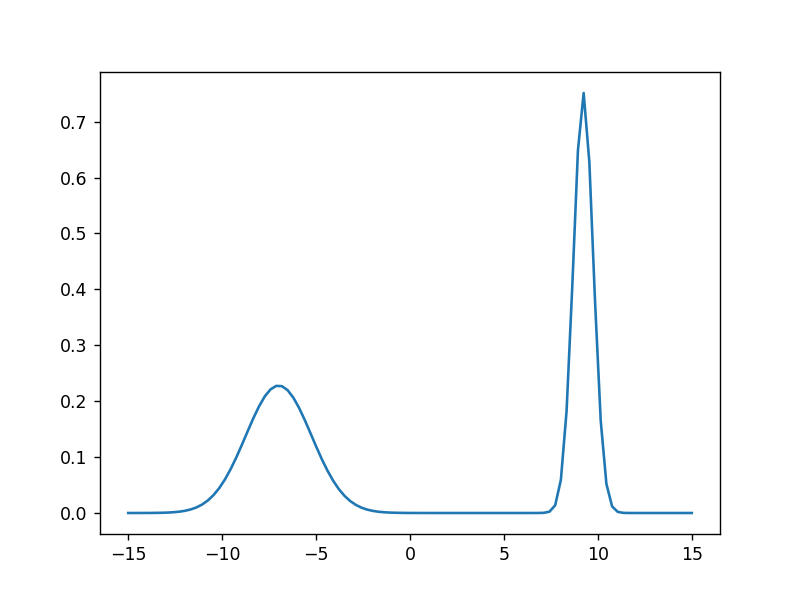

In [68]:
if(d==2):
    X,Y = np.meshgrid(np.linspace(1.5*xmin,1.5*xmax,100),np.linspace(1.5*xmin,1.5*xmax,100),indexing="ij")
    pos = np.dstack((X,Y))
    cum_distrib = np.zeros_like(X)
    for k in range(K):
        rd = multivariate_normal(mean=mu_k[k,:],cov=cov_mat[k,...])
        add = rd.pdf(pos)
        cum_distrib+=add
    plt.figure()
    plt.imshow(cum_distrib,cmap="Greys",aspect="auto",origin="lower",extent=[X.min(),X.max(),Y.min(),Y.max()])
    plt.colorbar()
if(d==1):
    X=np.linspace(1.5*xmin,1.5*xmax,100)
    
    cum_distrib = np.zeros_like(X)
    for k in range(K):
        rd = multivariate_normal(mean=mu_k[k,:],cov=cov_mat[k,...])
        add = rd.pdf(X)
        cum_distrib+=add
    plt.figure()
    plt.plot(X,cum_distrib)

# Define hidden variables probabilities

In [69]:
pi_k = np.random.rand(K)
pi_k /= np.sum(pi_k)
cum_sum_pi_k = np.concatenate((np.array([0]),np.cumsum(pi_k)[0:-1])) #np.concatenate((np.array([0]),np.cumsum(pi_k)))

# Construct data samples


z = np.random.rand(N)
Z = np.zeros((K,N))
for i in range(N):
    index = np.where(z[i]>cum_sum_pi_k)[0][-1]
    Z[index,i] = 1
    
X = np.zeros((d,N))
all_data_samples = []
for k in range(K):
    all_data_samples.append(multivariate_normal.rvs(mean = mu_k[k,:], cov = cov_mat[k,:,:], size=N).T)
all_data_samples = np.stack(all_data_samples)
for k in range(K):
    X+= all_data_samples[k,:,:]*Z[k,:]
del all_data_samples

In [70]:
z = np.random.rand(N)
Z = np.zeros((K,N))
for i in range(N): 
    index = np.where(z[i]>cum_sum_pi_k)[0][-1]
    Z[index,i] = 1

X = np.zeros((d,N)) 
all_data_samples = [] 
for k in range(K):
    all_data_samples.append(multivariate_normal.rvs(mean = mu_k[k,:], cov = cov_mat[k,:,:], size=N).T) 
all_data_samples = np.stack(all_data_samples) 
if(d !=1):
    for k in range(K): 
        X+= all_data_samples[k,:,:]*Z[k,:]
else:
    for k in range(K): 
        X+= all_data_samples[k,:]*Z[k,:]
del all_data_samples


# Visualize samples

<IPython.core.display.Javascript object>


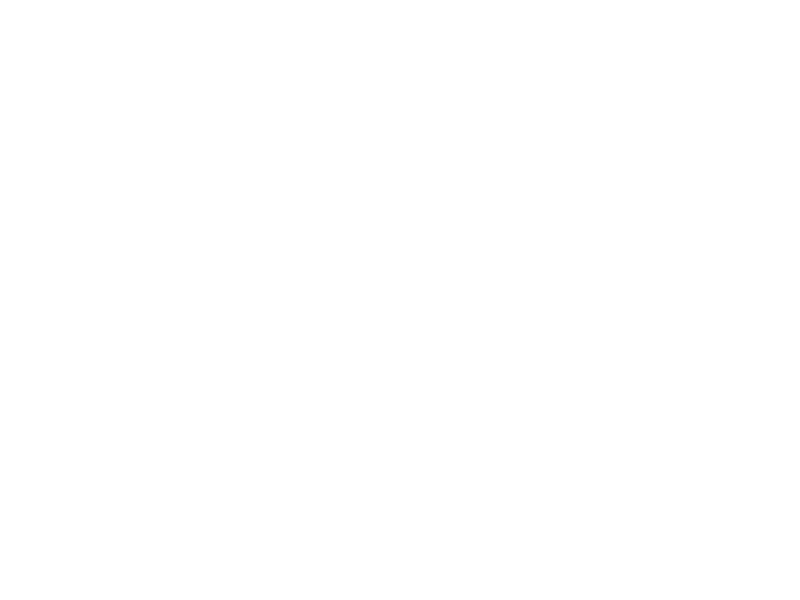

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [64]:
plt.figure()
if(d==2):
    plt.plot(X[0,:],X[1,:],"k.",markersize = 1)
if(d==1):
    d,h = np.histogram(X[0,:],bins=100)
    plt.plot(d)

# Implement EM algorithm
Known data: X,K
Result: pi_k, mu_k, cov_k

In [14]:
#initialize estimates
xmax_estimate = 10.
xmin=-xmax
estimate_mu_k = xmax*2*(np.random.rand(K*d).reshape((K,d))-0.5)
estimate_cov_mat = np.zeros((K,d,d))
for k in range(K):
    rd_matrix = np.random.randn(d,d)
    rd_matrix = rd_matrix.T@rd_matrix
    estimate_cov_mat[k,:,:] = rd_matrix
    del rd_matrix
estimate_pi_k = np.random.rand(K)
estimate_pi_k/=np.sum(estimate_pi_k)

In [15]:
def compute_E_step(X,mu,cov,pi):
    global K,N
    gamma = np.zeros((K,N))
    for k in range(K):
        gamma[k,:] = pi[k]*multivariate_normal.pdf(X.T,mean=mu[k,:],cov=cov[k,...])
    gamma/=np.sum(gamma,axis=0)
    return gamma

In [16]:
def compute_M_step(X,gamma):
    global K,N
    mu_new = np.zeros((K,d))
    cov_new = np.zeros((K,d,d))
    pi_new = np.zeros(K)
    Nk = np.sum(gamma,axis=1)
    pi_new = Nk/N
    for k in range(K):
        mu_new[k,:] = np.sum(X*gamma[k,:])/Nk[k]
        x_m_mu = (X.T-mu_new[k,:]).T
        cov_new[k,:,:] = (gamma[k,:]*x_m_mu)@(x_m_mu.T)*(1./Nk[k])

    return pi_new,mu_new,cov_new

In [17]:
def compute_log_likelihood(X,mu,cov,pi):
    LL = np.zeros_like(X)
    for k in range(K):
        LL[k,:] = (pi[k]*multivariate_normal.pdf(X.T,mean=mu[k,:],cov=cov[k,...]))
    LL = np.sum(np.log(np.sum(LL,axis=0)))
    return LL

In [18]:
num_it=100
LL = np.zeros(num_it)
for ite in tqdm(range(num_it)):
    gamma = compute_E_step(X, estimate_mu_k, estimate_cov_mat, estimate_pi_k)
    pi_new,mu_new,cov_new = compute_M_step(X,gamma)
    estimate_cov_mat = cov_new
    estimate_mu_k = mu_new
    estimate_pi_k = pi_new
   # LL[ite] = compute_log_likelihood(X,estimate_mu_k, estimate_cov_mat, estimate_pi_k)


In [19]:
estimate_pi_k

array([5.81471929e-20, 1.00000000e+00])

In [20]:
pi_k

array([0.62537085, 0.37462915])

In [50]:
# Générer un modèle aléatoire A 
A_mean = np.random.randint(100,300)
A_sd   = np.random.randint(10,30)
A_mean_orig = A_mean*1
A_sd_orig=A_sd*1
# Générer un modèle aléatoire B   
B_mean = np.random.randint(100,300)
B_sd   = np.random.randint(10,30)
B_mean_orig = B_mean*1
B_sd_orig=B_sd*1
N=10000
pa = 0.7
pb= 1-pa
x1 = np.random.normal(loc=A_mean, scale=A_sd,size=N)
x2 = np.random.normal(loc=B_mean, scale=B_sd,size=N)
z= np.random.rand(N)
X = np.where(z<pa,x1,x2)

A_mean = np.random.randint(100,300)
A_sd   = np.random.randint(10,30)
B_mean = np.random.randint(100,300)
B_sd   = np.random.randint(10,30)

# Faite 50 itérations... ( ca suffira)
for i in tqdm(range(5000)):

    # Pour chaque valeur de X, calculer la probabilité 
    # sous l'hypothèse A et B
    p_A = 0.3*norm(loc=A_mean, scale=A_sd).pdf(X)
    p_B =0.7* norm(loc=B_mean, scale=B_sd).pdf(X)

    # Calculer pour chaque valeur de X, un poids correspondant 
    # à son degrès d'appartenance à la loi A ou B.

    p_total  = p_A + p_B 
    weight_A = p_A / p_total
    weight_B = p_B / p_total

    # Exemple : Si la taille de 189cm appartient à la lois B 
    # alors weight_B(189) sera grand et weight_A(189) sera petit.

    #Ajustement des paramètres (μA,σA) et (μB,σB) en fonction du poids.

    A_mean = np.sum(X * weight_A )/ np.sum(weight_A)
    B_mean = np.sum(X * weight_B )/ np.sum(weight_B)

    A_sd   = np.sqrt(np.sum(weight_A * (X - A_mean)**2) / np.sum(weight_A))
    B_sd   = np.sqrt(np.sum(weight_B * (X - B_mean)**2) / np.sum(weight_B))

In [53]:
A_mean

221.38867979534066

In [54]:
A_mean_orig

222